# Stochastic, Mini Batch e Full Batch Gradient Descend
In questo notebook eseguiremo una classificazione utilizzando Full Batch Gradient Descend, Stochastic Gradient Descend e Mini Batch Gradient Descend al fine di confrontare le oscillazioni della funzione di costo per ognuno di essi.<br>

* **Full Batch Gradient Descend**: ad ogni iterazione viene utilizzato l'intero train set per aggiornare il valore dei pesi.
* **Stochastic Gradient Descend**: ad ogni iterazione viene utilizzato un singolo esmpio del train set per aggiornare il valore dei pesi.
* **Mini Batch Gradient Descend**: ad ogni iterazione viene utilizzato un determinato numero di esempi del train set (batch size) per aggiornare il valore dei pesi.<br>

**N.B**: un'iterazione è uno step del gradient descent, mentre un'epoca rappresenta un passaggio del gradient descent sull'intero train set.
<br><br>
Importiamo le librerie necessarie

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import log_loss

Ed utilizziamo la funzione *make_classification* di scikit-learn per creare un dataset ad-hoc in cui poter eseguire la nostra classificazione

In [2]:
X, Y = make_classification(n_samples=1250, n_features=4, n_informative=2, random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=0)

## Stochastic Gradient Descend

Lo Stochastic Gradient Descend (SGD) è una versione del Gradient Descend che utilizza un solo esempio di addestramento per volta durante l'ottimizzazione.
<br><br>
Possiamo utilizzare la classe <span style="font-family: Monaco">SGDClassifier</span> di scikit-learn, di default questa utilizza lo SGD per addestrare una SVM, ma possiamo modificare la tipologia di modello semplicemente cambiando la funzione di costo:

 * **hinge**: l'SGD addestrerà una SVM
 * **log**: l'SGD addestrerà una regressione logistica
 * **perceptron:** l'SGD addestrerà un percettrone
 
Per evitare cicli bisogna mischiare il train set ad ogni epoca, per farlo basta impostare il parametro <span style="font-family: Monaco">shuffle</span>
 a True (questo valore è settato di default, quindi è possibile anche ometterlo)
 <br><br>
**NOTA BENE** Lo Stochastic Gradient Descend è un processo stocastico (ma vah), anche utilizzando gli stessi iperparametri un modello fornirà risultati lievemente differenti se riaddestrato.

In [3]:
%%time
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss="log", verbose=False, shuffle=True) #verbose ci mostrerà informazioni sull'avanzamento dell'addestramento<
sgd.fit(X_train,Y_train)
print("LOSS: %.4f" % (log_loss(Y_test, sgd.predict_proba(X_test))))

LOSS: 0.1140
Wall time: 21 ms


La classe SGDClassifier ci mette a disposizione il metodo <span style="font-family: Monaco">partial_fit</span>, che ci permette di eseguire l'addestramento su una parte di dati definita da noi.<br>
Utilizziamo <span style="font-family: Monaco">partial_fit</span> per eseguire lo **stochastic gradient descend** e raccogliamo il valore della funzione di costo ad ogni iterazione.<br>
**NOTA BENE** se utilizziamo <span style="font-family: Monaco">partial_fit</span> dobbiamo mischiare i dati manualmente ad ogni epoca, per farlo possiamo utilizzare il metodo <span style="font-family: Monaco">shuffle</span> di scikit-learn.

In [4]:
%%time

from sklearn.utils import shuffle

epochs = 5

n_batches=X_train.shape[0]
batch_size = X_train.shape[0]/n_batches

classes = np.unique(Y_train)

sgd = SGDClassifier(loss="log")
sgd_losses = []

for epoch in range(epochs):
        X_shuffled, Y_shuffled = shuffle(X_train, Y_train)
        for batch in range(n_batches):
            batch_start = int(batch*batch_size)
            batch_end = int((batch+1)*batch_size)
            X_batch = X_shuffled[batch_start:batch_end,:]
            Y_batch = Y_shuffled[batch_start:batch_end]

            sgd.partial_fit(X_batch, Y_batch, classes=classes)
            loss = log_loss(Y_test, sgd.predict_proba(X_test),labels=classes)
            sgd_losses.append(loss)       
        print("Loss all'epoca %d = %.4f" % (epoch+1, loss))

Loss all'epoca 1 = 1.4296
Loss all'epoca 2 = 0.3821
Loss all'epoca 3 = 0.3814
Loss all'epoca 4 = 0.3259
Loss all'epoca 5 = 0.2189
Wall time: 5.86 s


I risultati non sono buoni perché il numero di epoche definito non è sufficente per far convergere il gradient descend e quindi per trovare i coefficenti ottimali del modello.
<br><br>
Visualizzaziamo il grafico della funzione di costo ad ogni iterazione.

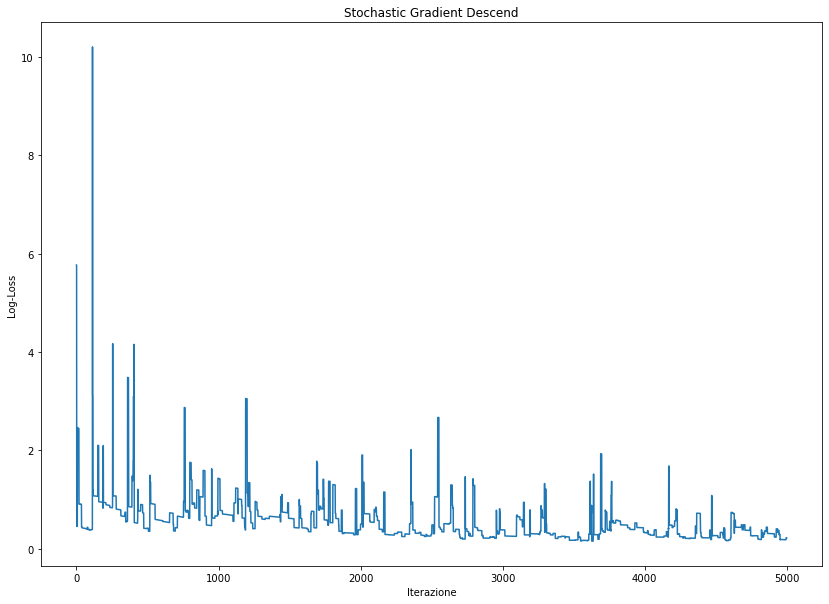

In [5]:
plt.figure(figsize=(14,10))
plt.title("Stochastic Gradient Descend")
plt.xlabel("Iterazione")
plt.ylabel("Log-Loss")
plt.plot(sgd_losses)

Il graico della funzione di costo per iterazione presenta un notevole rumore.

### Motivi per cui generalmente lo SGD è preferito al Full Batch
* Bisogna caricare in memoria un singolo esempio del train set alla volta, quindi è leggerissimo dal punto di vista computazionale.
* Se si ha un modello già addestrato e ci sono nuovi dati è sufficiente riaddestrare il modello solo sui nuovi dati (cosa impossibile nel full batch).
* E' molto meno soggetto al problema dei minimi locali in quanto le oscillazioni della funzione di costo consentono di sfuggire più facilmente a questa trappola.

### CONTRO
* Le oscillazioni della funzione di costo potrebbero essere così ampie da rendere difficile la convergenza verso il minimo globale.

## Full Batch Gradient Descend
Adesso eseguiamo un Full Batch Gradient Descend sempre servendoci della funzione <span style="font-family: Monaco">partial_fit</span>, per farlo è sufficente passare l'intero train set ad ogni iterazione.

In [6]:
%%time

epochs = 200

n_batches=1

batch_size = X_train.shape[0]/n_batches

classes = np.unique(Y)

sgd = SGDClassifier(loss="log")
full_losses = []

for epoch in range(epochs):
        loss = 0.
        X_shuffled, Y_shuffled = shuffle(X_train, Y_train)
        for batch in range(n_batches):
            batch_start = int(batch*batch_size)
            batch_end = int((batch+1)*batch_size)
            X_batch = X_shuffled[batch_start:batch_end,:]
            Y_batch = Y_shuffled[batch_start:batch_end]

            sgd.partial_fit(X_batch, Y_batch, classes=classes)
            loss = log_loss(Y_test, sgd.predict_proba(X_test),labels=classes)
            full_losses.append(loss)       
        print("Loss all'epoca %d = %.4f" % (epoch+1, loss))

Loss all'epoca 1 = 0.3180
Loss all'epoca 2 = 0.3285
Loss all'epoca 3 = 0.3875
Loss all'epoca 4 = 0.2582
Loss all'epoca 5 = 1.2382
Loss all'epoca 6 = 0.1833
Loss all'epoca 7 = 0.8199
Loss all'epoca 8 = 0.1687
Loss all'epoca 9 = 0.1422
Loss all'epoca 10 = 0.1677
Loss all'epoca 11 = 0.1234
Loss all'epoca 12 = 0.1144
Loss all'epoca 13 = 0.1739
Loss all'epoca 14 = 0.1194
Loss all'epoca 15 = 0.1297
Loss all'epoca 16 = 0.1408
Loss all'epoca 17 = 0.2806
Loss all'epoca 18 = 0.1199
Loss all'epoca 19 = 0.1231
Loss all'epoca 20 = 0.1232
Loss all'epoca 21 = 0.1104
Loss all'epoca 22 = 0.1155
Loss all'epoca 23 = 0.1162
Loss all'epoca 24 = 0.1084
Loss all'epoca 25 = 0.1125
Loss all'epoca 26 = 0.1301
Loss all'epoca 27 = 0.1211
Loss all'epoca 28 = 0.1200
Loss all'epoca 29 = 0.1432
Loss all'epoca 30 = 0.1158
Loss all'epoca 31 = 0.1193
Loss all'epoca 32 = 0.1098
Loss all'epoca 33 = 0.1087
Loss all'epoca 34 = 0.1159
Loss all'epoca 35 = 0.1095
Loss all'epoca 36 = 0.1124
Loss all'epoca 37 = 0.1262
Loss all'e

Il GD è riuscito a convergere fornendo un buon risultato, vediamo il grafico della funzione di costo ad ogni iterazione ( in questo caso un iterazione corrisponde ad un'epoca )

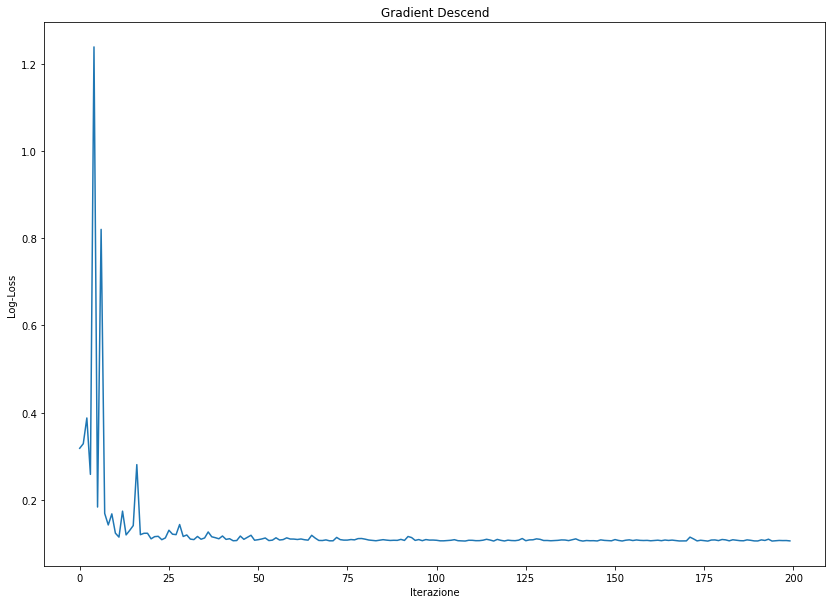

In [7]:
plt.figure(figsize=(14,10))
plt.title("Gradient Descend")
plt.xlabel("Iterazione")
plt.ylabel("Log-Loss")
plt.plot(full_losses)

La variazione della funzione di costo è molto più regolare rispetto allo SGD.

### Limiti del Full Batch
* Dato che utilizza l'intero train set ad ogni step, questo deve essere totalmente caricato in memoria, quindi è molto dispendioso da un punto di vista computazionale.
* Poco dinamico, in quanto se volessimo aggiungere nuoi dati dovremmo prima aggiungerli al train set e poi riaddestrare l'intero modello sul train set aggiornato.
* C'è il rischio che l'ottimizzazione si assesti in un minimo locale e non in un minimo globale, soprattutto quando si lavora in uno spazio dimensionale alto.

## Mini Batch Gradient Descend
Adesso eseguiamo un Mini Batch Gradient Descend con 10 batches, quindi, considerando che nel train set ci sono 1000 esempi, eseguiremo il Gradient Descend uilizzando 100 esempi per volta.

In [8]:
%%time

epochs = 50

n_batches=10

batch_size = X_train.shape[0]/n_batches

classes = np.unique(Y)

sgd = SGDClassifier(loss="log")
batch_losses = []

for epoch in range(epochs):
        X_shuffled, Y_shuffled = shuffle(X_train, Y_train)
        for batch in range(n_batches):
            batch_start = int(batch*batch_size)
            batch_end = int((batch+1)*batch_size)
            X_batch = X_shuffled[batch_start:batch_end,:]
            Y_batch = Y_shuffled[batch_start:batch_end]
            print(X_batch.shape)
            sgd.partial_fit(X_batch, Y_batch, classes=classes)
            loss = log_loss(Y_test, sgd.predict_proba(X_test),labels=classes)
            batch_losses.append(loss)       
        print("Loss all'epoca %d = %.4f" % (epoch+1, loss))

(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 1 = 1.0475
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 2 = 0.4296
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 3 = 0.3737
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 4 = 0.2149
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 5 = 0.2105
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 6 = 0.1715
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 7 = 0.1592
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
Loss all'epoca 8 = 0.2255
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)


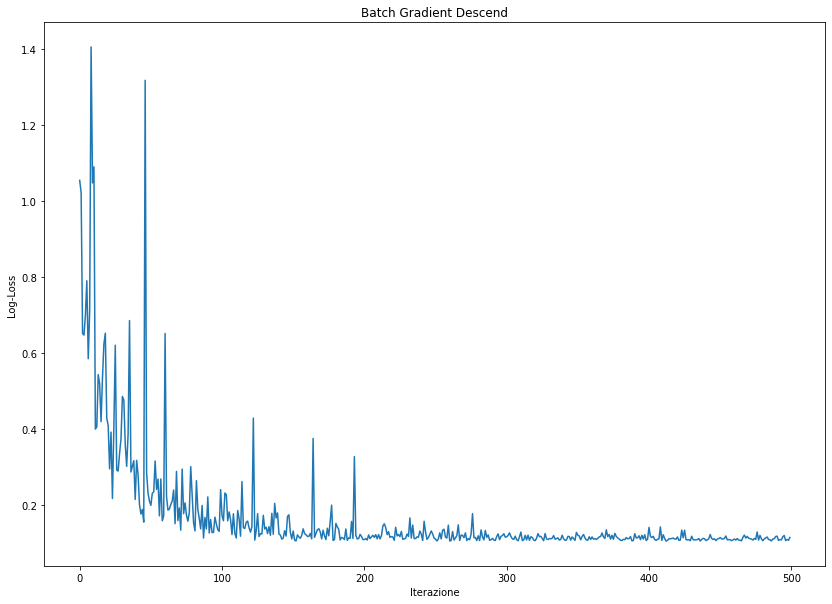

In [9]:
plt.figure(figsize=(14,10))
plt.title("Batch Gradient Descend")
plt.xlabel("Iterazione")
plt.ylabel("Log-Loss")
plt.plot(batch_losses)

### PRO e CONTRO
E' generalmente considerato fra i tre il "miglior compromesso" in quanto supera i limiti del full batch e le oscillazione della funzione di costo non saranno ampie come nello stochastic.

Il **batch size** è un iperparametro del modello.

## Il confronto
Confrontiamo le oscillazioni della funzione di costo per Full Batch, Stochastic e Mini Batch Gradient Descend, mettendole su di uno stesso grafico

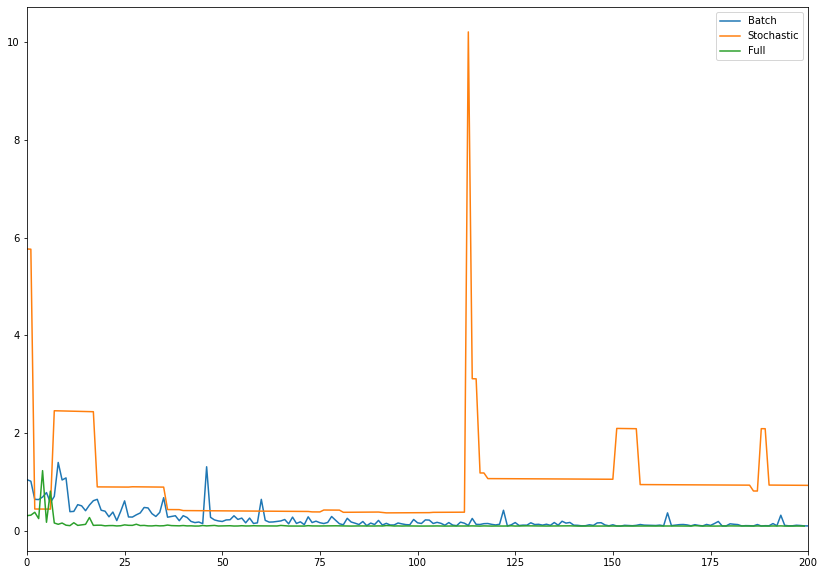

In [10]:
%matplotlib inline
plt.figure(figsize=(14,10))
plt.plot(batch_losses, label="Batch")
plt.plot(sgd_losses, label="Stochastic")
plt.plot(full_losses,label="Full")
plt.xlim(xmin=0,xmax=200)
plt.legend()
plt.show()